In [197]:
#DDPM forward diffusion is stochastic (random)
#DDIM forward diffusion is deterministic

In [198]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

X0 = Image.open(r"/content/2.jpg")
X0 = X0.resize((128,128))
device = "cuda" if torch.cuda.is_available() else "cpu"
X0 = transforms.ToTensor()(np.array(X0)).unsqueeze(0) * 2 - 1.0
X0 = X0.to(device)
X_t = X0

In [199]:
X0.shape

torch.Size([1, 3, 128, 128])

In [200]:
def get_XT_using_ddim(Xt, diffusion_model, device=device):
    time_steps = torch.flip(diffusion_model.scheduler.timesteps, dims=(0,))  # 0 .. 1000
    t = time_steps[:-1]  # takes all timesteps but deletes the last one
    t_next = time_steps[1:]  # takes all timesteps after the first one

    print("Original Xt shape:", Xt.shape)
    print("Original Xt min/max:", Xt.min().item(), Xt.max().item())

    for n, (i, j) in enumerate(zip(t.tolist(), t_next.tolist())):
        model_input = diffusion_model.scheduler.scale_model_input(Xt, i).to(device)

        with torch.no_grad():
            pred_epsilon_t = diffusion_model.unet(model_input, i)["sample"]

        alpha_bar_t_plus_delta_t = diffusion_model.scheduler.alphas_cumprod[j]
        alpha_bar_t = diffusion_model.scheduler.alphas_cumprod[i]

        pred_X0 = (Xt - pred_epsilon_t * torch.sqrt(1 - alpha_bar_t)) / torch.sqrt(alpha_bar_t)
        pred_X0 = pred_X0.clamp(-1, 1)

        X_t_plus_delta_t = torch.sqrt(alpha_bar_t_plus_delta_t) * pred_X0 + torch.sqrt(1 - alpha_bar_t_plus_delta_t) * pred_epsilon_t
        Xt = X_t_plus_delta_t

    print("Final XT shape:", Xt.shape)
    print("Final XT min/max:", Xt.min().item(), Xt.max().item())

    XT = Xt
    return XT

In [201]:
!pip install diffusers datasets transformers ftfy pyarrow==9.0.0

In [202]:
from diffusers import UNet2DModel

image_size=128
model = UNet2DModel(
    sample_size= image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [203]:
model.load_state_dict(torch.load("/content/drive/MyDrive/butterfly_diffusion_model8.pt"))

<All keys matched successfully>

In [204]:
from diffusers import DDPMPipeline
from diffusers import DDIMPipeline
from diffusers import DDPMScheduler
from diffusers import DDIMScheduler

scheduler = DDIMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
image_pipe = DDIMPipeline(unet=model, scheduler=scheduler)

In [205]:
X_t.shape

torch.Size([1, 3, 128, 128])

In [206]:
XT = get_XT_using_ddim(X_t, image_pipe)

Original Xt shape: torch.Size([1, 3, 128, 128])
Original Xt min/max: -0.9372549057006836 0.9764705896377563
Final XT shape: torch.Size([1, 3, 128, 128])
Final XT min/max: -22.78049659729004 26.9429874420166


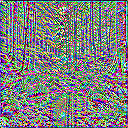

In [207]:
Image.fromarray(np.uint8(((XT[0].permute(1,2,0).cpu().clip(-1, 1) * 0.5 + 0.5) * 255).int().numpy()))

In [208]:
# DDIM
#X_t = XT
#for i, t in enumerate(scheduler.timesteps):
#  model_input = scheduler.scale_model_input(X_t, t)

#  with torch.no_grad():
#    pred_epsilon = image_pipe.unet(model_input, t)["sample"]

#  alpha_bar_t = scheduler.alphas_cumprod[t]
#  if t != 0:
#    alpha_bar_t_minus_delta_t = scheduler.alphas_cumprod[scheduler.timesteps[i-1]]
#  else:
#    alpha_bar_t_minus_delta_t = torch.tensor(1.0)

#  predicted_X_zero = (X_t - torch.sqrt(1 - alpha_bar_t) * pred_epsilon) / torch.sqrt(alpha_bar_t)
#  predicted_X_zero = predicted_X_zero.clamp(-scheduler.config.clip_sample_range, scheduler.config.clip_sample_range)

#  X_t_minus_delta_t = torch.sqrt(alpha_bar_t_minus_delta_t) * predicted_X_zero + torch.sqrt(1 - alpha_bar_t_minus_delta_t) * pred_epsilon
#  X_t = X_t_minus_delta_t

In [209]:
def reconstruct_image_from_noise(XT, scheduler, image_pipe):
    X_t = XT

    print("Initial X_t shape:", X_t.shape)
    print("Initial X_t min/max:", X_t.min().item(), X_t.max().item())

    for i, t in enumerate(scheduler.timesteps):
        model_input = scheduler.scale_model_input(X_t, t)
        with torch.no_grad():
            pred_epsilon = image_pipe.unet(model_input, t)["sample"]

        alpha_bar_t = scheduler.alphas_cumprod[t]
        if t != 0:
            alpha_bar_t_minus_delta_t = scheduler.alphas_cumprod[scheduler.timesteps[i + 1]]
        else:
            alpha_bar_t_minus_delta_t = torch.tensor(1.0)

        predicted_X_zero = (X_t - torch.sqrt(1 - alpha_bar_t) * pred_epsilon) / torch.sqrt(alpha_bar_t)
        predicted_X_zero = predicted_X_zero.clamp(-scheduler.config.clip_sample_range, scheduler.config.clip_sample_range)

        X_t_minus_delta_t = torch.sqrt(alpha_bar_t_minus_delta_t) * predicted_X_zero + torch.sqrt(1 - alpha_bar_t_minus_delta_t) * pred_epsilon
        X_t = X_t_minus_delta_t

    print("Final X_t shape:", X_t.shape)
    print("Final X_t min/max:", X_t.min().item(), X_t.max().item())

    return X_t

In [210]:
reconstructed_image = reconstruct_image_from_noise(XT, scheduler, image_pipe)

Streaming output truncated to the last 5000 lines.
Model input min/max: -14.674375534057617 11.284360885620117
Predicted epsilon shape: torch.Size([1, 3, 128, 128])
Predicted epsilon min/max: -19.620393753051758 14.912013053894043
Predicted X_zero shape: torch.Size([1, 3, 128, 128])
Predicted X_zero min/max: -1.0 1.0
X_t_minus_delta_t shape: torch.Size([1, 3, 128, 128])
X_t_minus_delta_t min/max: -14.641207695007324 11.26908016204834
---
Timestep: 498
Model input shape: torch.Size([1, 3, 128, 128])
Model input min/max: -14.641207695007324 11.26908016204834
Predicted epsilon shape: torch.Size([1, 3, 128, 128])
Predicted epsilon min/max: -19.619112014770508 14.929410934448242
Predicted X_zero shape: torch.Size([1, 3, 128, 128])
Predicted X_zero min/max: -1.0 1.0
X_t_minus_delta_t shape: torch.Size([1, 3, 128, 128])
X_t_minus_delta_t min/max: -14.619865417480469 11.253732681274414
---
Timestep: 497
Model input shape: torch.Size([1, 3, 128, 128])
Model input min/max: -14.619865417480469 11

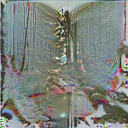

In [211]:
reconstructed_image = (reconstructed_image.squeeze().cpu().numpy() + 1) / 2
reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))
reconstructed_image = (reconstructed_image * 255).astype(np.uint8)
reconstructed_image = Image.fromarray(reconstructed_image)
reconstructed_image

In [212]:
#Image.fromarray(np.uint8(((X_t[0].permute(1,2,0).cpu().clip(-1,1) * 0.5 + 0.5) * 255).long().numpy()))